<a href="https://colab.research.google.com/github/DanayaDiarra/MachineLearning/blob/main/DeepL_ObjectDetection_food(French_fries).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## #French_Fries Detection


This project develops an efficient `French fries` detection system using `deep learning`. Built on `Faster R-CNN` with a `ResNet-50` backbone, the model is fine-tuned to accurately identify and localize French fries in images.

The system processes `YOLO-format` annotations and employs data augmentation techniques to enhance robustness. With optimized training using `AdamW optimizer and gradient clipping`, it achieves reliable detection with high confidence thresholds, making it suitable for real-world applications in food automation, quality control, and dietary analysis.

In [24]:
# # Install required packages
# !pip install torchvision --upgrade
# !pip install pycocotools
# !pip install albumentations
# !pip install matplotlib

In [43]:
# # Mount Drive
# from google.colab import drive
# drive.mount('/content/drive')

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import numpy as np

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [33]:
# Data functions
def get_transforms():
    train_transform = A.Compose([
        A.Resize(640, 640),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

    val_transform = A.Compose([
        A.Resize(640, 640),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

    return train_transform, val_transform

In [34]:
def create_dataset(images_dir, labels_dir, transform):
    class SimpleDataset(Dataset):
        def __init__(self):
            self.images_dir = Path(images_dir)
            self.labels_dir = Path(labels_dir)
            self.transform = transform
            self.image_files = list(self.images_dir.glob("*.jpg")) + list(self.images_dir.glob("*.png"))
            print(f"Found {len(self.image_files)} images")

        def __len__(self):
            return len(self.image_files)

        def __getitem__(self, idx):
            image_path = self.image_files[idx]
            label_path = self.labels_dir / f"{image_path.stem}.txt"

            # Load image
            image = cv2.imread(str(image_path))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            h, w = image.shape[:2]

            boxes = []
            labels = []

            # Load labels
            if label_path.exists():
                with open(label_path, 'r') as f:
                    for line in f.readlines():
                        data = line.strip().split()
                        if len(data) == 5:
                            class_id, x_center, y_center, bbox_w, bbox_h = map(float, data)

                            # Convert YOLO to Pascal VOC
                            x_center_abs = x_center * w
                            y_center_abs = y_center * h
                            bbox_w_abs = bbox_w * w
                            bbox_h_abs = bbox_h * h

                            x1 = max(0, x_center_abs - bbox_w_abs / 2)
                            y1 = max(0, y_center_abs - bbox_h_abs / 2)
                            x2 = min(w, x_center_abs + bbox_w_abs / 2)
                            y2 = min(h, y_center_abs + bbox_h_abs / 2)

                            if x2 > x1 and y2 > y1:
                                boxes.append([x1, y1, x2, y2])
                                labels.append(int(class_id) + 1)  # +1 for background

            # Apply transforms
            if boxes and self.transform:
                transformed = self.transform(image=image, bboxes=boxes, labels=labels)
                image = transformed['image']
                boxes = transformed['bboxes']
                labels = transformed['labels']
            else:
                # If no boxes, just resize and normalize
                image = cv2.resize(image, (640, 640))
                image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0

            target = {
                'boxes': torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32),
                'labels': torch.tensor(labels, dtype=torch.int64) if labels else torch.zeros(0, dtype=torch.int64),
            }

            return image, target

    return SimpleDataset()

def collate_fn(batch):
    return tuple(zip(*batch))

In [35]:
# Model functions
def create_model(num_classes=2):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')

    # Replace classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_features, num_classes
    )

    return model.to(device)

def train_model(model, train_loader, epochs=15):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

    print("Starting training...")

    # Lists to store losses
    epoch_losses = []
    batch_losses = []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        batch_count = 0

        for batch_idx, (images, targets) in enumerate(train_loader):
            # Filter valid samples (with boxes)
            valid_indices = [i for i, t in enumerate(targets) if len(t['boxes']) > 0]
            if not valid_indices:
                continue

            images = [img.to(device) for img in images]
            targets = [targets[i] for i in valid_indices]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            batch_count += 1

            # Store batch loss
            batch_losses.append(loss.item())

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}')

        avg_train_loss = train_loss / batch_count if batch_count > 0 else 0
        epoch_losses.append(avg_train_loss)

        print(f'Epoch {epoch+1}/{epochs}: Train Loss: {avg_train_loss:.4f}')

        # Save model every 5 epochs
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), f'/content/drive/MyDrive/model_epoch_{epoch+1}.pth')
            print('  ✓ Model saved!')

    # Save final model
    torch.save(model.state_dict(), '/content/drive/MyDrive/final_model.pth')
    print("Training completed!")

    return model, epoch_losses, batch_losses

In [36]:
def plot_losses(epoch_losses, batch_losses):
    # Create two plots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot epoch losses
    ax1.plot(range(1, len(epoch_losses) + 1), epoch_losses, 'b-o', linewidth=2, markersize=6)
    ax1.set_title('Epoch Losses', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Average Loss')
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(range(1, len(epoch_losses) + 1))

    # Plot batch losses (smoothed)
    if len(batch_losses) > 100:
        # Calculate moving average for better visualization
        window_size = max(1, len(batch_losses) // 100)
        smoothed_batch_losses = []
        for i in range(len(batch_losses)):
            start = max(0, i - window_size)
            end = min(len(batch_losses), i + window_size + 1)
            smoothed_batch_losses.append(np.mean(batch_losses[start:end]))
    else:
        smoothed_batch_losses = batch_losses

    ax2.plot(range(1, len(smoothed_batch_losses) + 1), smoothed_batch_losses, 'r-', alpha=0.7, linewidth=1)
    ax2.set_title('Batch Losses (Smoothed)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Batch')
    ax2.set_ylabel('Loss')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print final loss statistics
    print(f"\n📊 Loss Statistics:")
    print(f"   Final Epoch Loss: {epoch_losses[-1]:.4f}")
    print(f"   Minimum Epoch Loss: {min(epoch_losses):.4f}")
    print(f"   Maximum Epoch Loss: {max(epoch_losses):.4f}")
    print(f"   Total Batches: {len(batch_losses)}")

In [37]:
def predict(model, image, confidence=0.7):
    model.eval()
    with torch.no_grad():
        prediction = model([image.to(device)])[0]

    keep = prediction['scores'] > confidence
    return {
        'boxes': prediction['boxes'][keep].cpu(),
        'scores': prediction['scores'][keep].cpu(),
        'labels': prediction['labels'][keep].cpu()
    }

In [38]:
# Visualization
def plot_results(image, prediction, target=None):
    fig, axes = plt.subplots(1, 2 if target else 1, figsize=(15, 5))
    if not target:
        axes = [axes]

    # Convert image
    if isinstance(image, torch.Tensor):
        image_np = image.permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image_np = std * image_np + mean
        image_np = np.clip(image_np, 0, 1)
    else:
        image_np = image

    # Plot predictions
    axes[0].imshow(image_np)
    pred_count = len(prediction['boxes'])
    axes[0].set_title(f'Predictions ({pred_count}) - Confidence > 0.7')

    for box, score in zip(prediction['boxes'], prediction['scores']):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=3, edgecolor='red', facecolor='none')
        axes[0].add_patch(rect)
        axes[0].text(x1, y1-15, f'{score:.2f}',
                    bbox=dict(facecolor='red', alpha=0.9),
                    color='white', fontsize=10, fontweight='bold')

    # Plot ground truth
    if target and len(target['boxes']) > 0:
        axes[1].imshow(image_np)
        gt_count = len(target['boxes'])
        axes[1].set_title(f'Ground Truth ({gt_count})')

        for box in target['boxes']:
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=3, edgecolor='green', facecolor='none')
            axes[1].add_patch(rect)
            axes[1].text(x1, y1-15, 'GT',
                        bbox=dict(facecolor='green', alpha=0.7),
                        color='white', fontsize=10, fontweight='bold')

    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [41]:
# Main execution
def main():
    base_path = "/content/drive/MyDrive/proper_dataset"

    # Get transforms
    train_transform, val_transform = get_transforms()

    # Create datasets
    train_dataset = create_dataset(
        f"{base_path}/train/images",
        f"{base_path}/train/labels",
        train_transform
    )

    val_dataset = create_dataset(
        f"{base_path}/val/images",
        f"{base_path}/val/labels",
        val_transform
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

    print(f"\nDataset loaded:")
    print(f"Train: {len(train_dataset)} images")
    print(f"Val: {len(val_dataset)} images")

    # Create and train model
    model = create_model(num_classes=2)
    model, epoch_losses, batch_losses = train_model(model, train_loader, epochs=15)

    # Plot losses
    print("\n" + "="*50)
    print("Plotting Training Losses...")
    print("="*50)
    plot_losses(epoch_losses, batch_losses)

    # Load best model and test
    print("\n" + "="*50)
    print("Testing with trained model...")
    print("="*50)

    model.load_state_dict(torch.load('/content/drive/MyDrive/final_model.pth'))
        # Test on validation images
    for i in range(min(5, len(val_dataset))):
        image, target = val_dataset[i]
        prediction = predict(model, image, confidence=0.7)

        print(f"\nImage {i+1}:")
        print(f"  Ground truth: {len(target['boxes'])} objects")
        print(f"  Detected: {len(prediction['boxes'])} objects")
        if len(prediction['scores']) > 0:
            print(f"  Confidence scores: {[f'{s:.2f}' for s in prediction['scores']]}")

        plot_results(image, prediction, target)

Found 66 images
Found 66 images

Dataset loaded:
Train: 66 images
Val: 66 images
Starting training...
Epoch 1, Batch 0, Loss: 1.8129
Epoch 1, Batch 10, Loss: 0.2720
Epoch 1/15: Train Loss: 0.5386
Epoch 2, Batch 0, Loss: 0.3724
Epoch 2, Batch 10, Loss: 0.4082
Epoch 2/15: Train Loss: 0.4350
Epoch 3, Batch 0, Loss: 0.2831
Epoch 3, Batch 10, Loss: 0.2164
Epoch 3/15: Train Loss: 0.3868
Epoch 4, Batch 0, Loss: 0.1564
Epoch 4, Batch 10, Loss: 0.5442
Epoch 4/15: Train Loss: 0.4182
Epoch 5, Batch 0, Loss: 0.5557
Epoch 5, Batch 10, Loss: 0.9294
Epoch 5/15: Train Loss: 0.3872
  ✓ Model saved!
Epoch 6, Batch 0, Loss: 0.1929
Epoch 6, Batch 10, Loss: 0.4402
Epoch 6/15: Train Loss: 0.3642
Epoch 7, Batch 0, Loss: 0.2654
Epoch 7, Batch 10, Loss: 0.3870
Epoch 7/15: Train Loss: 0.3282
Epoch 8, Batch 0, Loss: 0.4584
Epoch 8, Batch 10, Loss: 0.2329
Epoch 8/15: Train Loss: 0.2952
Epoch 9, Batch 0, Loss: 0.1654
Epoch 9, Batch 10, Loss: 0.3464
Epoch 9/15: Train Loss: 0.2780
Epoch 10, Batch 0, Loss: 0.4173
Epo

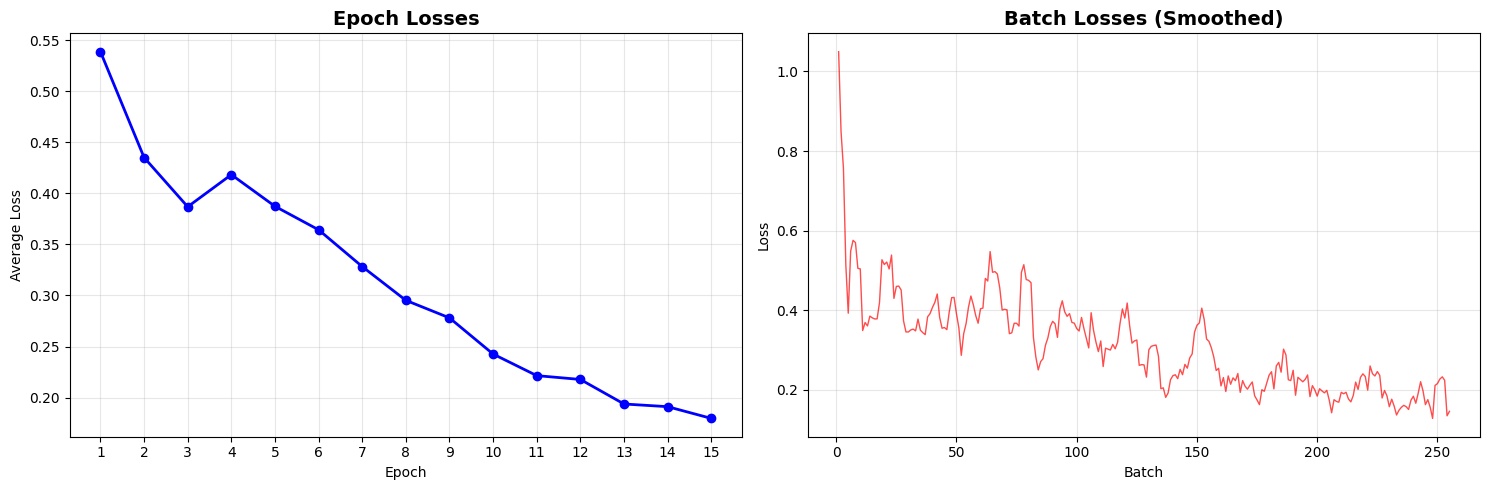


📊 Loss Statistics:
   Final Epoch Loss: 0.1797
   Minimum Epoch Loss: 0.1797
   Maximum Epoch Loss: 0.5386
   Total Batches: 255

Testing with trained model...

Image 1:
  Ground truth: 3 objects
  Detected: 3 objects
  Confidence scores: ['1.00', '1.00', '0.99']


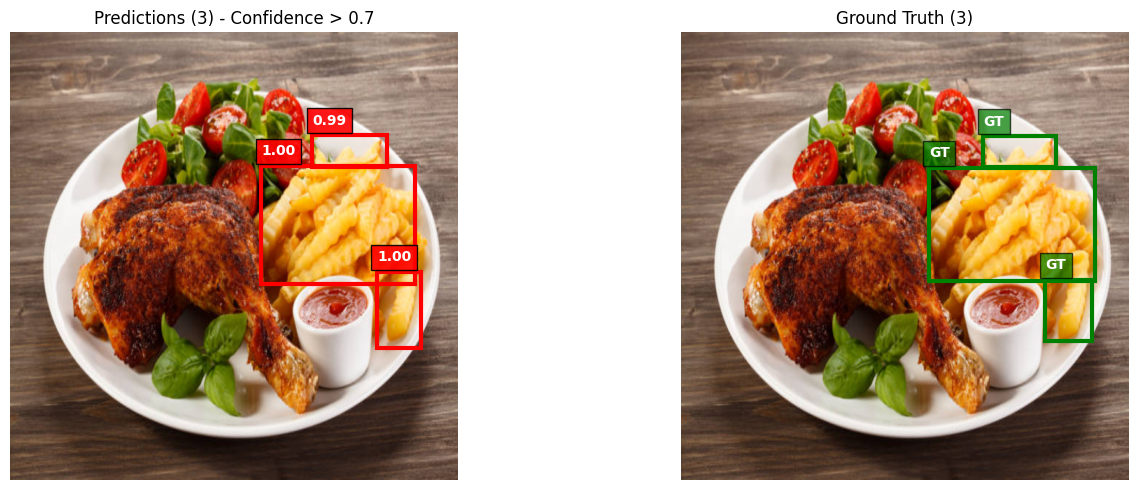


Image 2:
  Ground truth: 3 objects
  Detected: 3 objects
  Confidence scores: ['0.99', '0.99', '0.96']


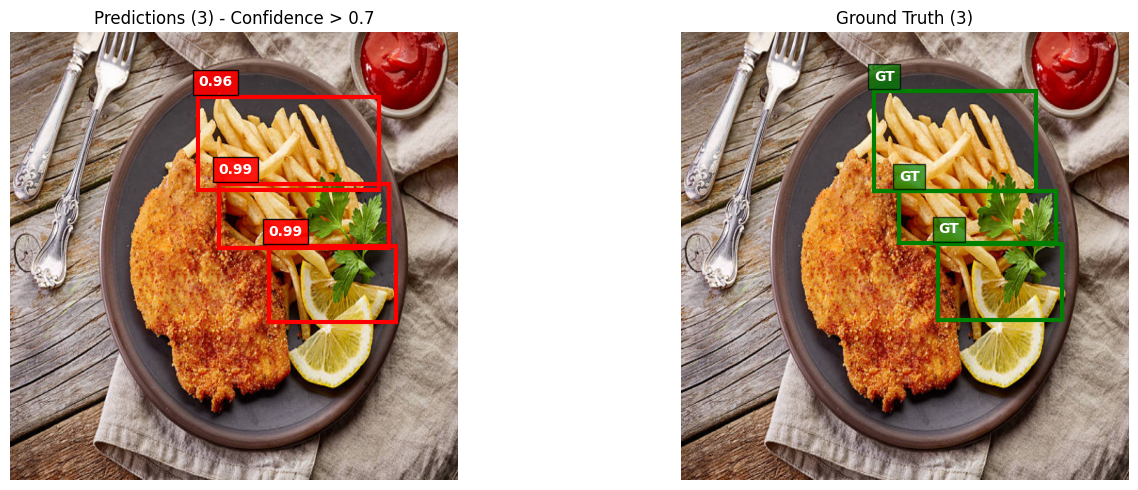


Image 3:
  Ground truth: 1 objects
  Detected: 1 objects
  Confidence scores: ['0.98']


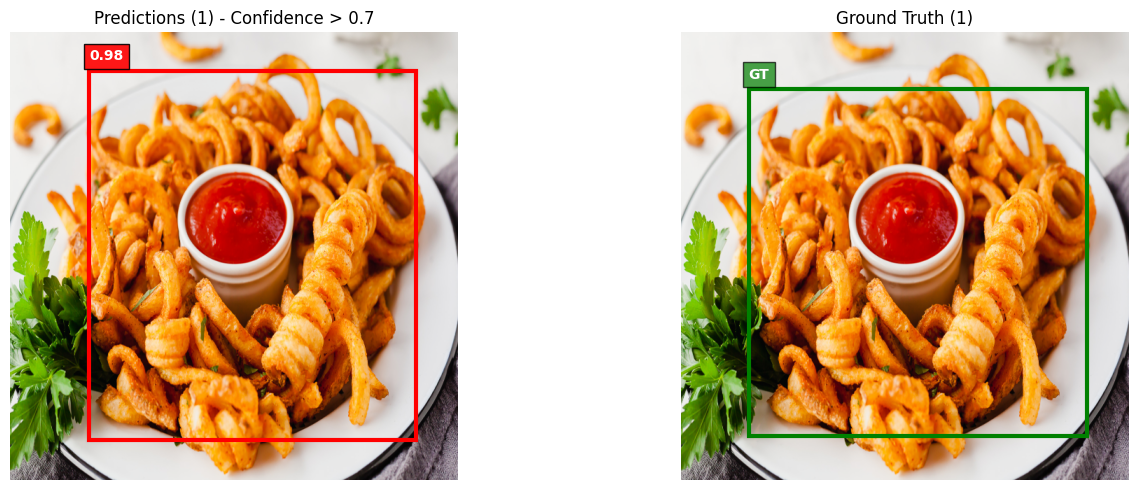


Image 4:
  Ground truth: 2 objects
  Detected: 3 objects
  Confidence scores: ['1.00', '1.00', '0.79']


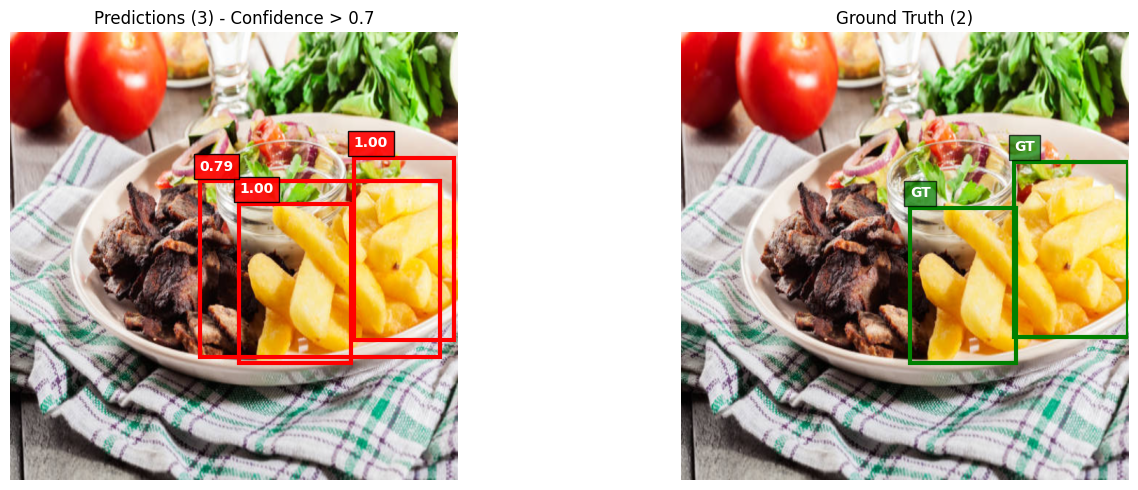


Image 5:
  Ground truth: 3 objects
  Detected: 3 objects
  Confidence scores: ['0.99', '0.99', '0.99']


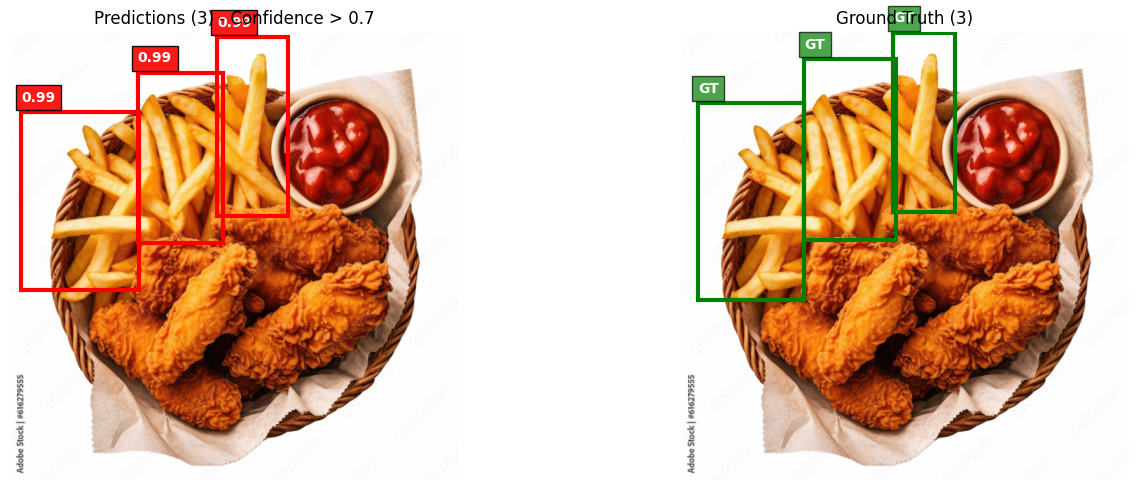

In [42]:
if __name__ == "__main__":
    main()